# Plot figures analogue analysis (poster/presentation)

### Packages and Directories

In [1]:
# --- Imports ---
import os
import sys
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import dask
from dask.distributed import Client, LocalCluster
from scipy.interpolate import griddata
import calendar
from datetime import datetime, timedelta
import cftime

from scipy import ndimage

import cartopy.crs as ccrs
import cartopy.feature as cfeature

# --- Custom Functions ---
# sys.path.append('/home/portal/script/python/precip_Cristina/')                    # tintin
sys.path.append('/home/alice/Desktop/work/git/myISACcode/python/precip_Cristina')   # alice
import functions_analogues_PrMax as fanPM
import functions_analogues_LUCAFAMOSS as fan

In [2]:
# Define directories for data and figures
# # tintin
# CERRA_dir = '/work_big/users/clima/portal/CERRA-Land/'
# ERA5_dir = '/work_big/users/clima/portal/ERA5/'
# CRCM5_dir = '/work_big/users/clima/portal/CRCM5-LE/'
# fig_dir = '/home/portal/figures/analogues/'

# alice
CERRA_dir = '/media/alice/Crucial X9/portal/data_CNR/CERRA-Land/'
ERA5_dir = '/media/alice/Crucial X9/portal/data_CNR/ERA5/'
CRCM5_dir = '/media/alice/Crucial X9/portal/data_CNR/CRCM5-LE/'
fig_dir = '/home/alice/Desktop/CNR/ENCIRCLE/materiale_alice/figures/analogues/'
diff_dir = './analogue_data/analogue_differences/'

### Parameters

In [3]:
# Variable
var_analogues = 'psl'  # Variable used to find the analogues, e.g. 'psl' for sea level pressure

# Quantile and analogue number
qtl_LE = 0.99
no_analogues = 18

# Number of ensemble members
no_membs = 30

# List of members
list_membs = [name for name in os.listdir(CRCM5_dir + 'psl') if os.path.isdir(os.path.join(CRCM5_dir + 'psl', name))]
list_membs = sorted(list_membs)[:no_membs]  # Select the first 'no_membs' members

# List epochs
list_year_ranges = [[1955, 1974], [2004, 2023], [2080, 2099]] # past [1955-1974], present [2004-2023], near-future [2030-2049], far future [2080-2099]
no_epochs = len(list_year_ranges)

In [4]:
# Event
lselect = 'alertregions'  # 'Italy' or 'wide-region' or 'alert-regions'
no_node = 1
no_event = 1
event_origin = 'CRCM5-LE'  # 'ERA5' or 'CRCM5-LE'
str_event_ERA5 = f'node{no_node}-extreme{no_event}-{lselect}'  # 'Italy' or 'wide-region' or 'alert-regions'
str_event_BAM = f'BAM-node{no_node}-extreme{no_event}-{lselect}'  # 'Italy' or 'wide-region' or 'alert-regions'

# ERA5
df_events = pd.read_excel(CERRA_dir+'events_cum_on_above99_alert_regions.xlsx', sheet_name=no_node-1)
time_ERA5event = df_events['Time'].iloc[no_event-1] + pd.Timedelta('12h')
doy_ERA5event =  time_ERA5event.timetuple().tm_yday

# BAM
BAM_info = fanPM.get_best_model_analogue_info(no_node, no_event, var_analogues)
time = datetime.strptime(BAM_info['date'], "%Y-%m-%d")
time_BAMevent = cftime.DatetimeNoLeap(time.year, time.month, time.day, hour=0, minute=0, second=0)
doy_BAMevent = time_BAMevent.timetuple().tm_yday
member_BAMevent = BAM_info['member']

# Define lon-lat box of event
box_event = fanPM.box_event_PrMax_alertregions(no_node,no_event)

### Plot event ERA5 (first row of figures) and BAM (second row of figures)

In [5]:
# Upload data ERA5

# mslp
dmslp_event_ERA5 = fanPM.load_ERA5_data('mslp', 'daily', time_ERA5event, box_event, l_anom=True)
mslp_clim_ERA5 = fanPM.load_ERA5_clim('mslp', doy_ERA5event, box_event, l_smoothing=True)
# Regrid 
dmslp_event_ERA5 = fanPM.regrid_with_xesmf(dmslp_event_ERA5, box_event, resolution=0.5)
mslp_clim_ERA5 = fanPM.regrid_with_xesmf(mslp_clim_ERA5, box_event, resolution=0.5)

# precip

/home/alice/anaconda3/envs/xesmf_env/lib/python3.13/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/home/alice/anaconda3/envs/xesmf_env/lib/python3.13/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


In [6]:
# Upload data CRCM5

# psl
BAM_files, BAM_files_clim = fanPM.get_anomaly_climatology_paths_CRCM5_bymonth(CRCM5_dir, var_analogues, [member_BAMevent], [[time_BAMevent]])
list_ds = fanPM.open_member_datasets(BAM_files, combine='by_coords', expand_member_dim=True)
list_ds_clim = fanPM.open_member_datasets(BAM_files_clim, combine='by_coords', expand_member_dim=True)
dmslp_BAM = xr.concat(list_ds, dim='member')['psl'] * 0.01
mslp_BAM = xr.concat(list_ds_clim, dim='member')['psl'] * 0.01
# Select the time of the event
dmslp_BAM = dmslp_BAM.sel(time=time_BAMevent).squeeze('member')
doy_clim = mslp_BAM.time.dt.dayofyear.values
mask_time = doy_clim == doy_BAMevent
mslp_BAM = mslp_BAM.sel(time=mask_time).squeeze('time').squeeze('member')

# precip
precip_files = fanPM.get_precipitation_paths_CRCM5_bymonth(CRCM5_dir, [member_BAMevent], [[time_BAMevent]])
# Make list of datasets and add 'member' coordinate
list_ds = fanPM.open_member_datasets(precip_files, combine='by_coords', expand_member_dim=True)
# Concatenate, scale, choose date and select box
pr_tmp = xr.concat(list_ds, dim='member')['pr'] * 3600 # Convert from mm/s*24 to mm/day
pr_BAM = pr_tmp.sel(time=time_BAMevent + timedelta(hours=12)).squeeze('member')

# Select lon lat mask for the event
lon_mask, lat_mask = fanPM.lonlat_mask(dmslp_BAM.lon.values, dmslp_BAM.lat.values, box_event)
mask_BAM = lat_mask[:, np.newaxis] & lon_mask
mask_xr_BAM = xr.DataArray(
    mask_BAM,
    dims=["lat", "lon"],
    coords={"lat": dmslp_BAM.lat.values, "lon": dmslp_BAM.lon.values},
)

# Apply mask
dmslp_BAM = dmslp_BAM.where(mask_xr_BAM, drop=True)
mslp_BAM = mslp_BAM.where(mask_xr_BAM, drop=True)
pr_BAM = pr_BAM.where(mask_xr_BAM, drop=True)

Opening files for member: kbw
Opening files for member: kbw
Opening files for member: kbw


In [7]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from cartopy.util import add_cyclic_point

def _apply_common_map_style(ax, lonlat_bounds=None, title=None):
    """Applies consistent coastlines, borders, gridlines, extent, and title."""
    ax.coastlines(linewidth=1.2)
    # ax.add_feature(cfeature.BORDERS, linewidth=0.8)
    if lonlat_bounds is not None:
        ax.set_extent(lonlat_bounds, crs=ccrs.PlateCarree())

    gl = ax.gridlines(
        draw_labels=True, linestyle="--", color="gray", alpha=0.5, linewidth=0.7
    )
    gl.top_labels = False
    gl.right_labels = False

    if title:
        ax.set_title(title, fontsize=12, weight="bold")

    return ax


def plot_precipitation(ax, lonlat_bounds, precip, precip_levels, title):
    """Plots the precipitation data for a given timestep."""

    lon = precip.lon.values
    lat = precip.lat.values
    precip, lon1 = fanPM.add_cyclic_point(precip, coord=lon)

    # Apply uniform style
    _apply_common_map_style(ax, lonlat_bounds, title)

    # Colormap settings
    cmap = plt.get_cmap("YlGnBu")
    norm = mcolors.BoundaryNorm(boundaries=precip_levels, ncolors=cmap.N, extend="max")

    # Plot precipitation
    mesh = ax.pcolormesh(
        lon1, lat, precip, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm
    )

    # Colorbar
    cbar = plt.colorbar(
        mesh,
        ax=ax,
        orientation="vertical",
        pad=0.05,
        boundaries=precip_levels,
        ticks=precip_levels,
        extend="max",
        shrink=0.8,
    )
    cbar.set_label("24h precipitation [mm]", fontsize=10)


def plot_anom_event(ax, varname, lon, lat, anom_event, clim, title):
    """Plots the anomaly and DOY climatology for a given event (mslp or z500)."""

    # Set variable-specific intervals
    if varname == "z500":
        cbar_int = 50
        levels_clim = np.arange(5000, 6000, 25)
        cbar_label = "$\\Delta$Z500 (m)"
    elif varname == "mslp":
        cbar_int = 2
        levels_clim = np.arange(950, 1050, 1)
        cbar_label = "$\\Delta$mslp (hPa)"

    # Symmetric colorbar range
    vmin, vmax = np.nanmin(anom_event), np.nanmax(anom_event)
    cbar_center = max(abs(vmin), abs(vmax)) // cbar_int * cbar_int + cbar_int
    cbar_levels = np.arange(-cbar_center, cbar_center + cbar_int, cbar_int)

    # Apply uniform style
    _apply_common_map_style(ax, title=title)

    # Filled anomalies
    cf = ax.contourf(
        lon,
        lat,
        anom_event,
        transform=ccrs.PlateCarree(),
        cmap="RdBu_r",
        levels=cbar_levels,
        extend="both",
    )
    # Climatology contours
    contours = ax.contour(
        lon,
        lat,
        clim,
        transform=ccrs.PlateCarree(),
        levels=levels_clim,
        colors="black",
        linewidths=0.8,
    )
    ax.clabel(contours, inline=True, fontsize=8, fmt="%.0f")

    # Colorbar
    plt.colorbar(cf, ax=ax, shrink=0.8, label=cbar_label)
    return ax

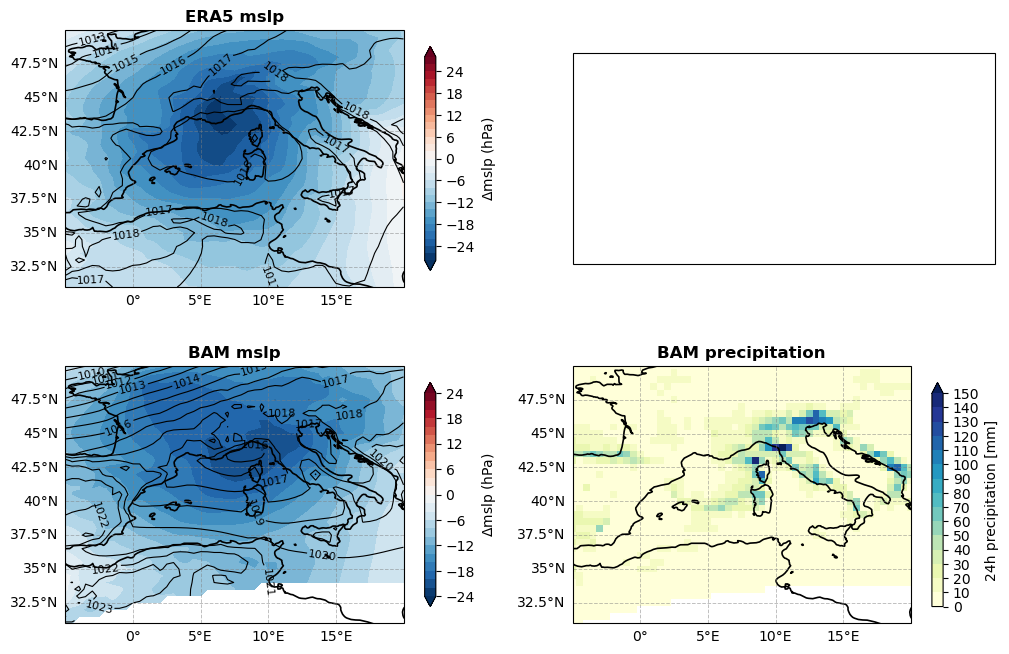

In [9]:
fig, ax = plt.subplots(
    nrows=2, ncols=2, figsize=(12, 8),
    subplot_kw={'projection': ccrs.PlateCarree()}
    )
ax = ax.ravel()

# Plot ERA5 mslp
plot_anom_event(ax[0], 'mslp', dmslp_event_ERA5.lon, dmslp_event_ERA5.lat, dmslp_event_ERA5, mslp_clim_ERA5, 'ERA5 mslp')
plot_anom_event(ax[2], 'mslp', dmslp_BAM.lon, dmslp_BAM.lat, dmslp_BAM, mslp_BAM, 'BAM mslp')

# Plot BAM precipitation
timestr_BAMevent = str(pr_BAM.time.dt.strftime("%Y-%m-%d %H:%M UTC").values)[:10]
plot_precipitation(ax[3], box_event, pr_BAM, 
                         precip_levels=np.arange(0, 155, 10), title='BAM precipitation')

# # Save the figure
# fig.savefig(fig_dir+'pr_BAM-'+var_analogues+'_node'+str(no_node)+'_extreme'+str(no_event)+'-alertregions_'+str_months+'_'+str(year_range[0])+'-'+str(year_range[1])+'_CRCM5-LE_'+str(no_membs)+'membs.png')

### Plot analogue mean in different epochs (30 members)

In [10]:
# Parameters
varname = 'psl'

In [11]:
# Upload analogue data
list_ds_anom = []  # List to store difference datasets
list_ds_clim = []  # List to store difference datasets
for i in range(no_epochs):
    year_range = list_year_ranges[i]
    str_year_range = "-".join(str(x) for x in year_range)
    suffix_file = f"_{varname}_{str_event_BAM}_{int(100*qtl_LE)}pct_{str_year_range}_CRCM5_{no_membs}membs.nc"
        
    # Load analogue anomalies
    anom_file = f'{diff_dir}analogues-{var_analogues}_anomaly{suffix_file}'
    if not os.path.exists(anom_file):
        print(f'File {anom_file} does not exist. Skipping epoch {i+1}.')
        continue
    ds_anom = xr.open_dataset(anom_file)
    list_ds_anom.append(ds_anom)

    # Load climatologies
    clim_file = f'{diff_dir}analogues-{var_analogues}_climatology{suffix_file}'
    if not os.path.exists(clim_file):
        print(f'File {clim_file} does not exist. Skipping epoch {i+1}.')
        continue
    ds_clim = xr.open_dataset(clim_file)
    list_ds_clim.append(ds_clim)

Text(0.5, 0.98, 'composites of BAM analogues (30 members)')

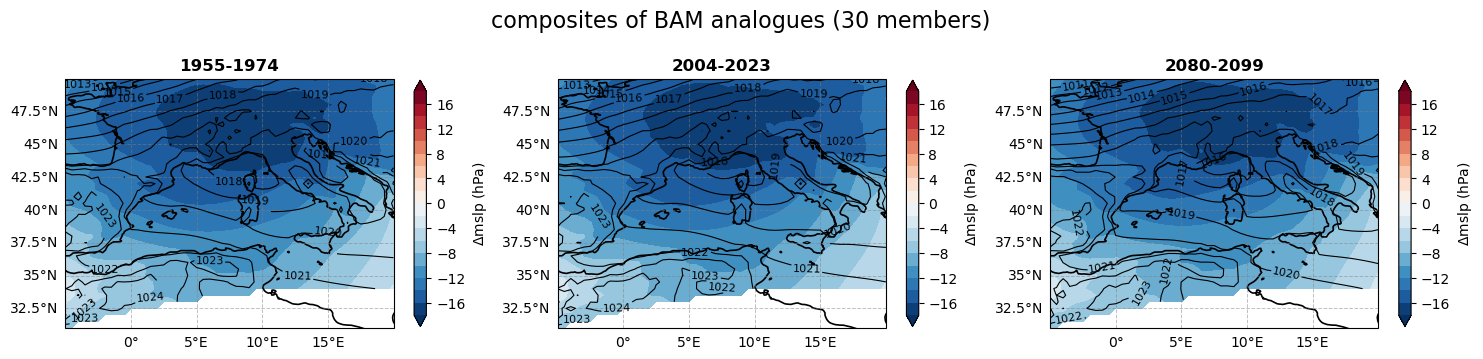

In [12]:
fig, ax = plt.subplots(
    nrows=1, ncols=no_epochs, figsize=(6*no_epochs, 4),
    sharey=True,
    subplot_kw={'projection': ccrs.PlateCarree()}
    )
ax = ax.ravel()

# Plot
for i in range(no_epochs):
    plot_anom_event(
        ax[i], 'mslp', 
        list_ds_anom[i].lon, list_ds_anom[i].lat, 
        list_ds_anom[i][varname], list_ds_clim[i][varname], 
        f'{list_year_ranges[i][0]}-{list_year_ranges[i][1]}'
    )
fig.suptitle(f'composites of BAM analogues ({no_membs} members)', fontsize=16)

# # Save the figure
# fig.savefig(fig_dir+'pr_BAM-'+var_analogues+'_node'+str(no_node)+'_extreme'+str(no_event)+'-alertregions_'+str_months+'_'+str(year_range[0])+'-'+str(year_range[1])+'_CRCM5-LE_'+str(no_membs)+'membs.png')